In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cmo
from matplotlib.patches import Polygon
from copy import copy
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
lw_voronoi = 0.
lw_gl = .2
ec_voronoi = None #'w'

plotannual = True

In [3]:
#    C%type_icefree_land                        = 1
#    C%type_icefree_ocean                       = 2
#    C%type_grounded_ice                        = 3
#    C%type_floating_ice                        = 4
#    C%type_groundingline_gr                    = 5
#    C%type_groundingline_fl                    = 6
#    C%type_calvingfront_gr                     = 7
#    C%type_calvingfront_fl                     = 8
#    C%type_margin                              = 9
#    C%type_coastline                           = 10

In [4]:
vmax = 200
vmin = -10
linthresh = .3
linscale = .2

fracpos = (np.log10(vmax/linthresh)+linscale)/(np.log10(vmax/linthresh)+np.log10(-(vmin/linthresh))+2*linscale)
nneg = np.int_((1-fracpos)*256)

hilim = vmax
N = np.int_(np.log10(vmax/hilim)/(np.log10(vmax/linthresh)+np.log10(-(vmin/linthresh))+2*linscale) * 256)
print(N)

colors1 = plt.get_cmap('cmo.dense_r')(np.linspace(1-nneg/(256-nneg),1.,nneg+1))
colors2 = plt.get_cmap('gist_heat_r')(np.linspace(.02, 1, 256-nneg-1))
#colors2 = plt.get_cmap('CMRmap_r')(np.linspace(.02, 1, 256-nneg-1))
colors3 = plt.get_cmap('PuRd_r')(np.linspace(0., .5, N))

colors1 = plt.get_cmap('cmo.ice_r')(np.linspace(1-nneg/(256-nneg),.8,nneg+1))
colors2 = plt.get_cmap('inferno')(np.linspace(0., 1, 256-nneg-1))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2, colors3))

cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)
norm1=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale)
ticks1 = [-10,-3,-1,-.3,0,.3,1,3,10,30,100]

#cmap2 = plt.get_cmap('cmo.thermal')
colors = plt.get_cmap('nipy_spectral')(np.linspace(0,.95,256))
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)
norm2 = mpl.colors.Normalize(vmin=-2.0,vmax=1.5)

cmap3 = plt.get_cmap('cmo.haline')
norm3 = mpl.colors.Normalize(vmin=33,vmax=34.5)

#Uabs
cmap5 = plt.get_cmap('cmo.balance')
#norm5 = mpl.colors.Normalize(vmin=-0.4,vmax=0.4)
norm5 = mpl.colors.Normalize(vmin=-1.0,vmax=1.0)

cmap6 = plt.get_cmap('cmo.balance')
norm6 = mpl.colors.Normalize(vmin=-1.0e-5,vmax=1.0e-5)

cmap7 = plt.get_cmap('cmo.curl')
norm7 = mpl.colors.Normalize(vmin=-1.0e-4,vmax=1.0e-4)

cmap8 = plt.get_cmap('cmo.curl')
norm8 = mpl.colors.Normalize(vmin=-1.0e-3,vmax=1.0e-3)

#HU
cmap9 = plt.get_cmap('cmo.balance')
norm9 = mpl.colors.Normalize(vmin=-10.0,vmax=10.0)

#Melt, Holland style
cmap10 = plt.get_cmap('hot_r')
norm10 = mpl.colors.Normalize(vmin=0,vmax=250)

cmap11 = plt.get_cmap('turbo')
norm11 = mpl.colors.Normalize(vmin=0,vmax=1000)

0


In [8]:
def plot_voronoi(run,var,cmap,norm,label,ticks=None):
    s = 1

    fig = plt.figure(figsize=(7,10))

    ax0 = fig.add_subplot(111)

    #Add colorbars
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax0,extend='both',shrink=.8)
    if ticks is not None:
        cb.set_ticks(ticks)
        cb.set_ticklabels(ticks)
    cb.set_label(label)

    ax0.set_xticklabels([])
    ax0.set_yticklabels([])

    #Open data on new mesh
    ds = xr.open_dataset(f'../output/{run}/main_output_ANT_{s:05d}.nc')

    #Make up axes and labels
    ax0.set_xlim(ds.xmin+0e3,ds.xmax-0e3)
    ax0.set_ylim(ds.ymin+0e3,ds.ymax-0e3)
    ax0.set_aspect(1)
    ax0.grid(color='.3',linewidth=.1)

    #Allocate for storage of polygons
    VAR = {}

    # Gather points surrounding vertex (quasi-voronoi)
    for v in range(len(ds.vi)):
        polyx = []
        polyy = []
        for n in range(ds.niTri[v].data):
            c = ds.iTri[n,v].data-1 #Neighbouring triangle
            polyx.append(ds.Tricc[0,c].data)
            polyy.append(ds.Tricc[1,c].data)             
        #TO DO: Append edge points here

        #Accumulate into polygons
        points = np.array([polyx,polyy]).T #Converted to km
        VAR[v] = Polygon(points,edgecolor=ec_voronoi,linewidth=lw_voronoi)

        #Add polygons to axes
        ax0.add_patch(VAR[v])

    print(f"{s:02d}: Added cells")

    i = -1
    #Loop over vertex to fill colours and plot grounding line
    for v in range(len(ds.vi)):
        if var == 'BMB':
            vvar = -ds.BMB[i,v]
        elif var == 'melt':
            vvar = ds.melt[i,v]*3600*24*365.25
        elif var == 'T':
            vvar = ds.T_lad[i,v]
        elif var == 'S':
            vvar = ds.S_lad[i,v]
        elif var == 'diffS':
            vvar = ds.diffS[i,v]
        elif var == 'uabs_surf':
            vvar = ds.uabs_surf[i,v]
        elif var == 'Hs':
            vvar = ds.Hs[i,v]

        #Fill colours based on data
        if ds.mask[i,v].data in [2]: #Ocean
            VAR[v].set_facecolor('teal')
        elif var in ['uabs_surf','Hs']:
            VAR[v].set_facecolor(cmap(norm(vvar)))
        elif ds.mask[i,v].data in [4,6,8]: #Ice shelf
            VAR[v].set_facecolor(cmap(norm(vvar)))
        else: #Grouded
            VAR[v].set_facecolor('.8')
        
        # Plot grounding line segments
        if ds.mask[i,v].data in [5,7]: #gl_gr or ca_gr
            for n in range(ds.nC[v].data):
                c = ds.C[n,v].data-1
                if ds.mask[i,c].data in [6,8]: #neighbouring gl_fl or ca_fl
                    cs = np.intersect1d(ds.iTri[:,v],ds.iTri[:,c])[1:]-1
                    lenn = .5*(ds.R[v]+ds.R[c])
                    ax0.plot(ds.Tricc[0,cs],ds.Tricc[1,cs],lw=lw_gl*lenn/10000,c='yellow',solid_capstyle='round')
                elif ds.mask[i,c].data in [2]: #Ocean
                    cs = np.intersect1d(ds.iTri[:,v],ds.iTri[:,c])[1:]-1
                    lenn = .5*(ds.R[v]+ds.R[c])
                    ax0.plot(ds.Tricc[0,cs],ds.Tricc[1,cs],lw=lw_gl*lenn/10000,c='orange',solid_capstyle='round')                       

    #Save figure
    plt.savefig(f'../video/{var}_{run}.pdf')

    ds.close()


In [6]:
def plot_triangle(run,var,cmap,norm,label):
    s = 1

    fig = plt.figure(figsize=(7,10))

    ax0 = fig.add_subplot(111)

    #Add colorbars
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax0,extend='both',shrink=.8)
    #cb.set_ticks(ticks1)
    #cb.set_ticklabels(ticks1)
    cb.set_label(label)

    ax0.set_xticklabels([])
    ax0.set_yticklabels([])

    #Open data on new mesh
    ds = xr.open_dataset(f'../output/{run}/main_output_ANT_{s:05d}.nc')

    #Make up axes and labels
    ax0.set_xlim(ds.xmin+0e3,ds.xmax-0e3)
    ax0.set_ylim(ds.ymin+0e3,ds.ymax-0e3)
    ax0.set_aspect(1)
    ax0.grid(color='.3',linewidth=.1)

    #Allocate for storage of polygons
    VAR = {}

    for ti in range(len(ds.ti)):
        polyx = []
        polyy = []
        for n in range(3):
            c = ds.Tri[n,ti].data-1 #Neighbouring vertex
            polyx.append(ds.V[0,c].data)
            polyy.append(ds.V[1,c].data)             

        #Accumulate into polygons
        points = np.array([polyx,polyy]).T #Converted to km
        VAR[ti]  = Polygon(points,edgecolor=ec_voronoi,linewidth=lw_voronoi)

        ax0.add_patch(VAR[ti])

    print(f"{s:02d}: Added cells")

    i = 0
    # Loop over triangles
    for ti in range(len(ds.ti)):
        if var == 'Uabs':
            vvar = (ds.U_lad[i,ti]**2+ds.V_lad[i,ti]**2)**.5 * np.sign(ds.U_lad[i,ti])
        elif var == 'viscU':
            vvar = (ds.viscU[i,ti])
        elif var == 'divQU':
            vvar = (ds.divQU[i,ti])
        elif var == 'U':
            vvar = ds.U_lad[i,ti]
        elif var == 'HU':
            vvar = ds.HU_lad[i,ti]
        if vvar != 0:
            VAR[ti].set_facecolor(cmap(norm((vvar))))
        elif ds.fraction_gr_b[i,ti]==0:
            VAR[ti].set_facecolor('teal')
        else:
            VAR[ti].set_facecolor('.8')
    
    for v in range(len(ds.vi)):
        # Plot grounding line segments
        if ds.mask[i,v].data in [5,7]: #gl_gr or ca_gr
            for n in range(ds.nC[v].data):
                c = ds.C[n,v].data-1
                if ds.mask[i,c].data in [6,8]: #neighbouring gl_fl or ca_fl
                    cs = np.intersect1d(ds.iTri[:,v],ds.iTri[:,c])[1:]-1
                    lenn = .5*(ds.R[v]+ds.R[c])**.5
                    ax0.plot(ds.Tricc[0,cs],ds.Tricc[1,cs],lw=lw_gl*lenn/10,c='yellow',solid_capstyle='round')
                elif ds.mask[i,c].data in [2]: #Ocean
                    cs = np.intersect1d(ds.iTri[:,v],ds.iTri[:,c])[1:]-1
                    lenn = .5*(ds.R[v]+ds.R[c])**.5
                    ax0.plot(ds.Tricc[0,cs],ds.Tricc[1,cs],lw=lw_gl*lenn/10,c='orange',solid_capstyle='round')                       

    #Save figure
    plt.savefig(f'../video/{var}_{run}.pdf')

    ds.close()


62: Added cells


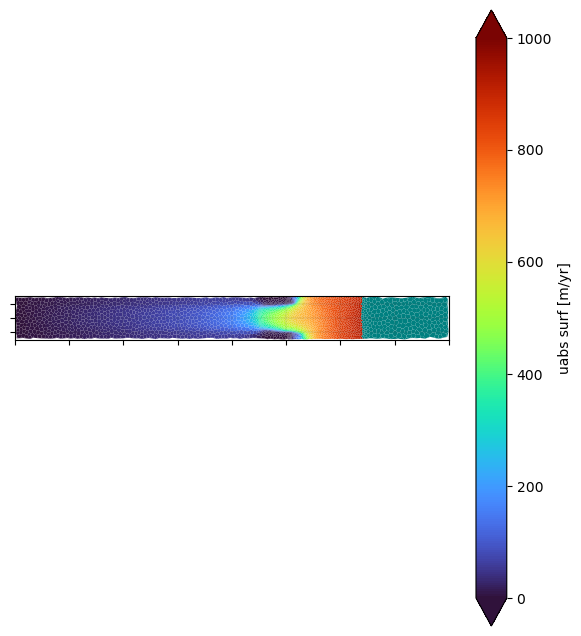

In [22]:
run = 'MISMIP_spinup_1'
#run = 'CrossDots'
#run = 'FRIS'
#run = 'Ross'
#run = 'George'
#run = 'Totten'
#run = 'ASE'
#run = 'Thwaites'
#run = 'Antarctica'

plot_voronoi(run,'uabs_surf',cmap11,norm11,'uabs surf [m/yr]')
#plot_voronoi(run,'melt',cmap10,norm10,'Basal mass balance [m/yr]')

01: Added cells


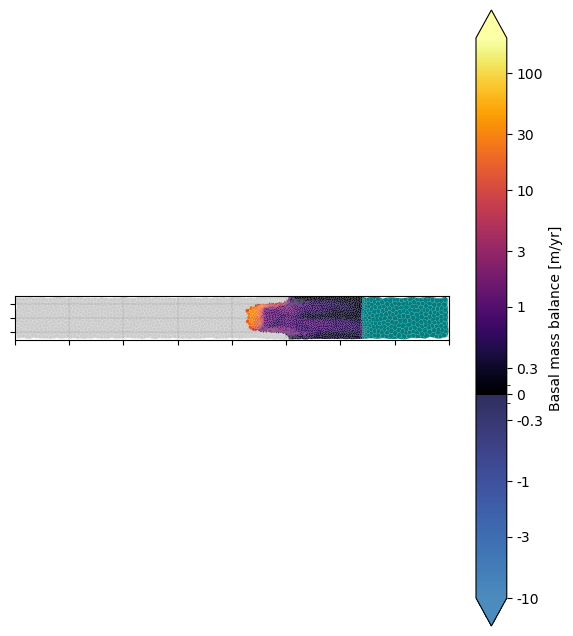

In [10]:
run = 'MISMIP_run1b'
#run = 'CrossDots'
#run = 'FRIS'
#run = 'Ross'
#run = 'George'
#run = 'Totten'
#run = 'ASE'
#run = 'Thwaites'
#run = 'Antarctica'

plot_voronoi(run,'BMB',cmap1,norm1,'Basal mass balance [m/yr]',ticks1)
#plot_voronoi(run,'melt',cmap10,norm10,'Basal mass balance [m/yr]')

01: Added cells


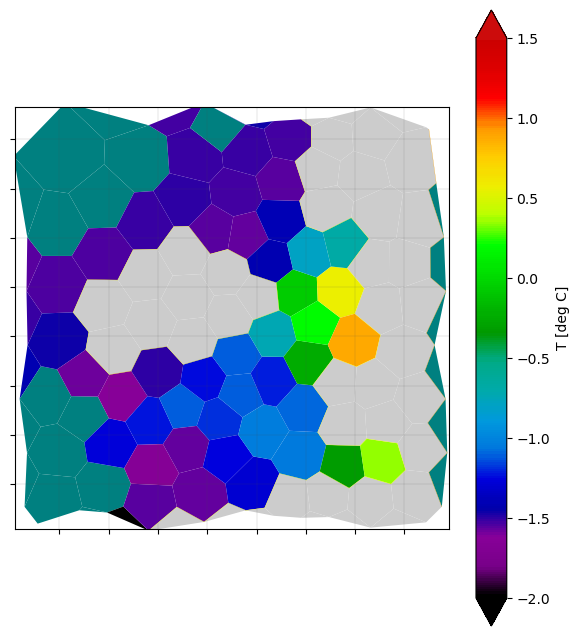

In [124]:
plot_voronoi('CrossDots','T',cmap2,norm2,'T [deg C]')
#plot_voronoi('George','T',cmap2,norm2,'T [deg C]')

01: Added cells


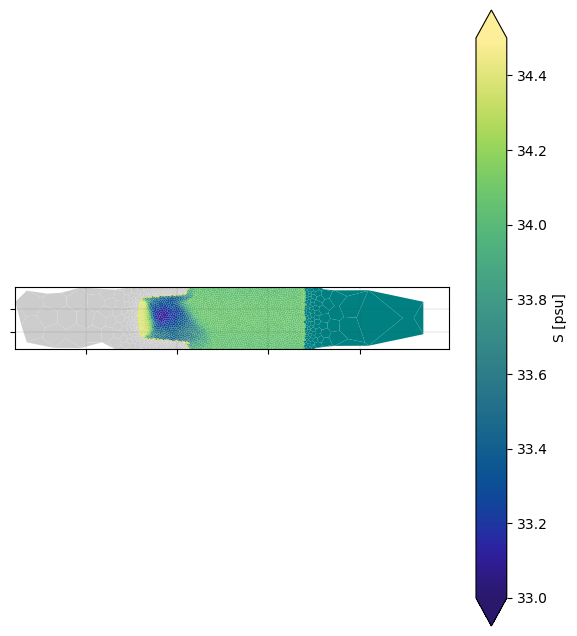

In [11]:
run = 'MISOMIP_8km_spinup'

plot_voronoi(run,'S',cmap3,norm3,'S [psu]')

01: Added cells


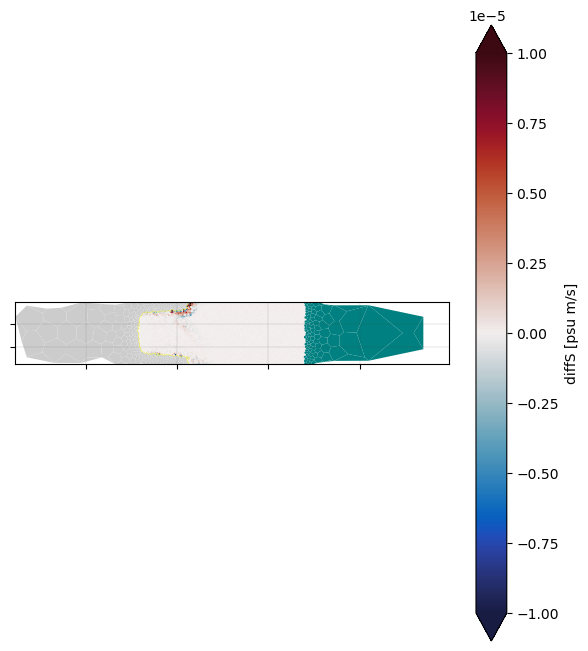

In [16]:
run = 'MISOMIP_8km_spinup'

plot_voronoi(run,'diffS',cmap6,norm6,'diffS [psu m/s]')

01: Added cells


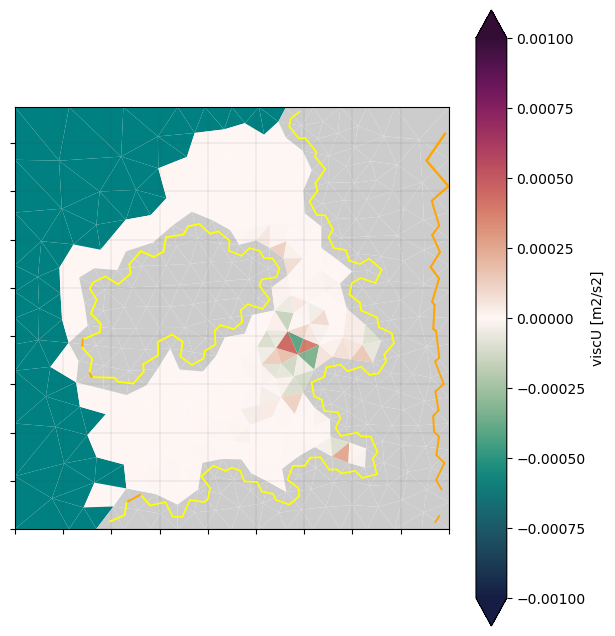

In [62]:
#run = 'MISOMIP_8km_spinup'
run = 'CrossDots'

plot_triangle(run,'viscU',cmap8,norm8,'viscU [m2/s2]')

01: Added cells


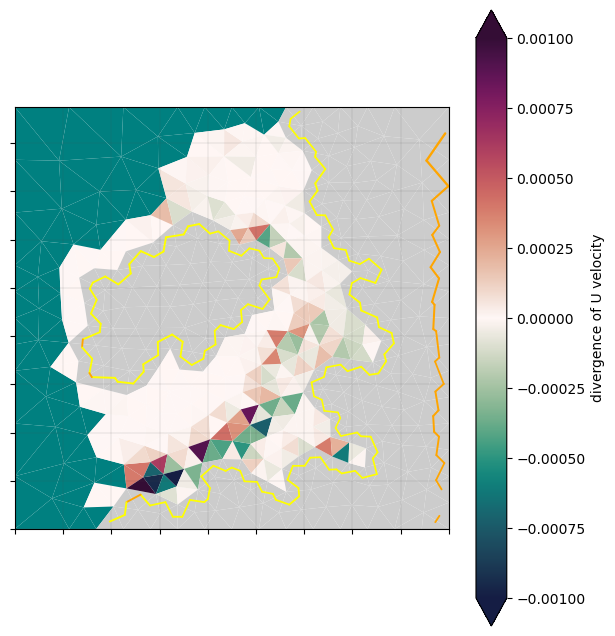

In [79]:
#run = 'MISOMIP_8km_spinup'
#run = 'FRIS'
#run = 'Ross'
run = 'CrossDots'
#run = 'George'
#run = 'ASE'

plot_triangle(run,'divQU',cmap8,norm8,'divergence of U velocity')

01: Added cells


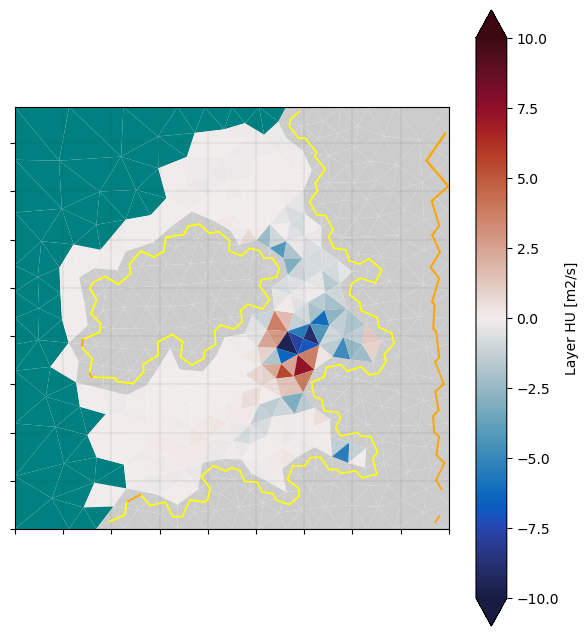

In [69]:
#run = 'MISOMIP_8km_spinup'
#run = 'FRIS'
#run = 'Ross'
run = 'CrossDots'
#run = 'George'
#run = 'ASE'

plot_triangle(run,'HU',cmap9,norm9,'Layer HU [m2/s]')

01: Added cells


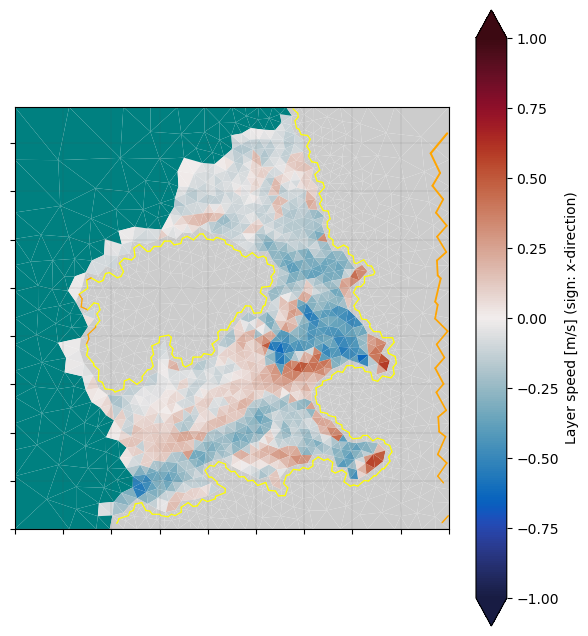

In [80]:
#run = 'MISOMIP_8km_spinup'
#run = 'FRIS'
#run = 'Ross'
run = 'CrossDots'
#run = 'George'
#run = 'ASE'
#run = 'Thwaites'
#run = 'Antarctica'
#run = 'Totten'

plot_triangle(run,'Uabs',cmap5,norm5,'Layer speed [m/s] (sign: x-direction)')

01: Added cells


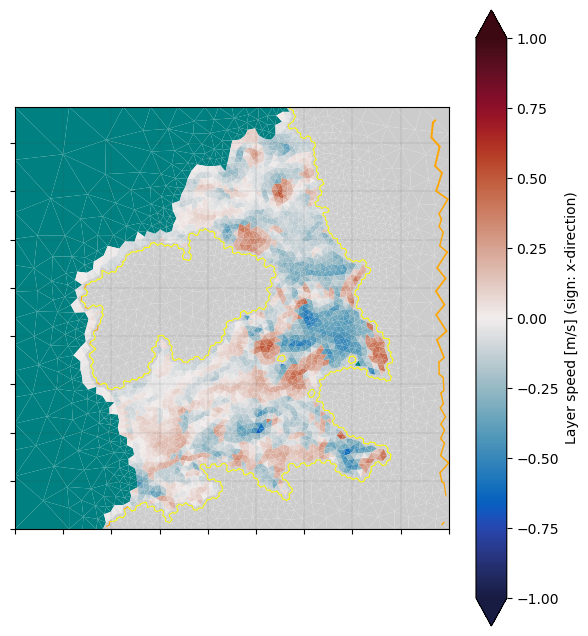

In [86]:
#run = 'MISOMIP_8km_spinup'
#run = 'FRIS'
#run = 'Ross'
run = 'CrossDots'
#run = 'George'
#run = 'ASE'
#run = 'Thwaites'
#run = 'Antarctica'
#run = 'Totten'

plot_triangle(run,'Uabs',cmap5,norm5,'Layer speed [m/s] (sign: x-direction)')

01: Added cells


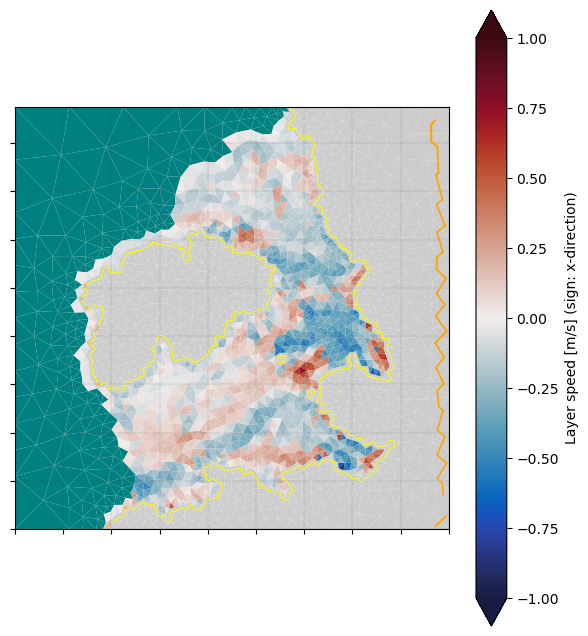

In [91]:
#run = 'MISOMIP_8km_spinup'
#run = 'FRIS'
#run = 'Ross'
run = 'CrossDots'
#run = 'George'
#run = 'ASE'
#run = 'Thwaites'
#run = 'Antarctica'
#run = 'Totten'

plot_triangle(run,'Uabs',cmap5,norm5,'Layer speed [m/s] (sign: x-direction)')

01: Added cells


IndexError: index 0 is out of bounds for axis 0 with size 0

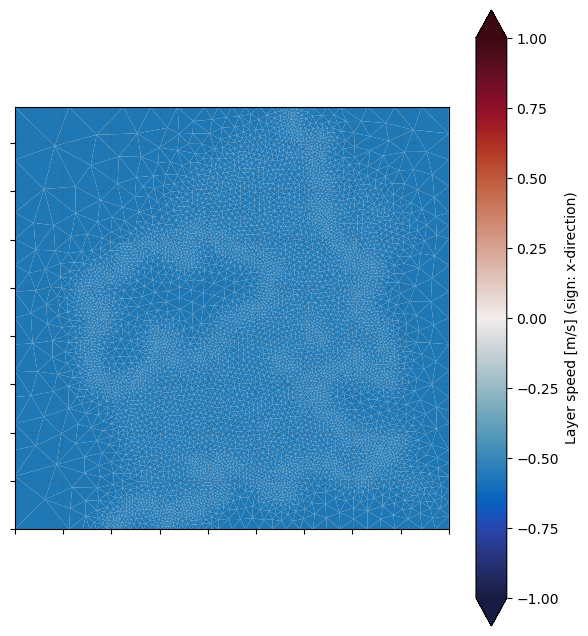

In [95]:
#run = 'MISOMIP_8km_spinup'
#run = 'FRIS'
#run = 'Ross'
run = 'CrossDots'
#run = 'George'
#run = 'ASE'
#run = 'Thwaites'
#run = 'Antarctica'
#run = 'Totten'

plot_triangle(run,'Uabs',cmap5,norm5,'Layer speed [m/s] (sign: x-direction)')